# Final Project

### <span style="color:gray"> Violet Davis and Annie Friar </span>

###
`Data Exploration`

---

In [1]:
# Import libraries

# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.regularizers import l2

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
NORMAL_IMAGE_PATH = 'drive/MyDrive/Final_Project_Data/normal/' # Class as 1
GLIOMA_IMAGE_PATH = 'drive/MyDrive/Final_Project_Data/glioma_tumor/' # Class as 2
MENINGIOMA_IMAGE_PATH = 'drive/MyDrive/Final_Project_Data/meningioma_tumor/' # Class as 3
PITUITARY_IMAGE_PATH = 'drive/MyDrive/Final_Project_Data/pituitary_tumor/' # Class as 4

#import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset


In [2]:
# read image
indx=0
images = []
labels = []

labels_index = 0

for idx, img in enumerate(os.listdir(NORMAL_IMAGE_PATH)):
    img = load_img(
    NORMAL_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx, 0))
    labels_index = idx

normal_index = labels_index + 1

for idx, img in enumerate(os.listdir(GLIOMA_IMAGE_PATH)):
    img = load_img(
    GLIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+normal_index, 1))
    labels_index = idx

glioma_index = normal_index + labels_index + 1

for idx, img in enumerate(os.listdir(MENINGIOMA_IMAGE_PATH)):
    img = load_img(
    MENINGIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+glioma_index, 2))
    labels_index = idx

meningioma_index = glioma_index + labels_index + 1

for idx, img in enumerate(os.listdir(PITUITARY_IMAGE_PATH)):
    img = load_img(
    PITUITARY_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+meningioma_index, 3))

In [3]:
labels = np.array(labels)

In [4]:
labels_df = pd.DataFrame(labels,
                   columns=['img_num', 'Label'])

In [6]:
labels_df['Label'].value_counts()

2    913
1    901
3    844
0    438
Name: Label, dtype: int64

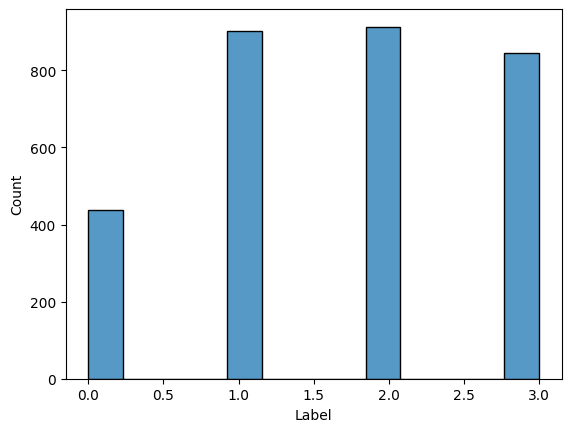

In [19]:
# histogram
sns.histplot(
    data=labels_df,
    stat="count",
    x = "Label"
);

## Split Images Datasets

`Correct for data imbalance`

In [5]:
np.random.seed(1234)

n_size = 438

normal = labels_df[labels_df['Label'] == 0]
glioma = labels_df[labels_df['Label'] == 1]
meningioma = labels_df[labels_df['Label'] == 2]
pituitary = labels_df[labels_df['Label'] == 3]

# randomly draw 438 images from each classes
temp_normal = list(np.random.choice(
    normal.img_num,
    size=n_size,
    replace=False
))

temp_glioma = list(np.random.choice(
    glioma.img_num,
    size=n_size,
    replace=False
))

temp_meningioma = list(np.random.choice(
    meningioma.img_num,
    size=n_size,
    replace=False
))


temp_pituitary = list(np.random.choice(
    pituitary.img_num,
    size=n_size,
    replace=False
))

In [6]:
image_list = []
labels_list = []

for num in temp_normal:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_glioma:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_meningioma:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_pituitary:
    image_list.append(images[num])
    labels_list.append(labels[num])

In [22]:
print("Length of Image List: ", len(image_list))
print("Length of Labels List: ", len(labels_list))

Length of Image List:  1752
Length of Labels List:  1752


In [7]:
images_mini = []
y_mini = []

for img in image_list:

# transform image to array
    img = img_to_array(img)

    # append to images
    images_mini.append(img)

images_mini = np.stack(images_mini)

for label in labels_list:
    y_mini.append(label[1])

y_mini = np.array(y_mini)

In [24]:
images_mini.shape

(1752, 256, 256, 3)

In [25]:
y_mini.shape

(1752,)

## Image Augmentation

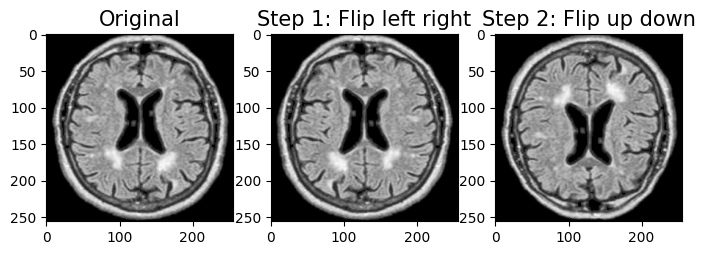

In [9]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# flip left right
ax = fig.add_subplot(1, 5, 2)
img_flip = tf.image.flip_left_right(image)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 1: Flip left right', size=15);

# flip up down
ax = fig.add_subplot(1, 5, 3)
img_flip = tf.image.flip_up_down(image)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 2: Flip up down', size=15);


In [8]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 256, 256, 1)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 256, 256, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 256, 256, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 256, 224, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    shuffle = np.random.permutation(np.arange(len(images)))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

    # rescale image to [0,1]
    X_train = tf.image.rgb_to_grayscale(X_train)/255.0
    X_val = tf.image.rgb_to_grayscale(X_val)/255.0
    X_test = tf.image.rgb_to_grayscale(X_test)/255.0

    ### image augmentation on training data ###
    ###########################################

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train)

    # random flip up
    X_train_augm = tf.image.random_flip_up_down(X_train_augm)

    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (2102, 256, 256, 1)
y_train shape (2102,)
X_val shape (350, 256, 256, 1)
y_val shape (350,)
X_test shape (351, 256, 256, 1)
y_test shape (351,)


In [29]:
validate_split = pd.DataFrame(y_train)

In [30]:
validate_split.value_counts()

0    542
3    528
2    518
1    514
dtype: int64

In [31]:
y_train.shape

(2102,)

In [32]:
type(y_train)

numpy.ndarray

##SVD

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [12]:
X_train_example = X_train[:1]

In [11]:
def svd_compressor(image, order):
    """Returns the compressed image channel at the specified order"""

    # Create an array filled with zeros having the shape of the image
    compressed = np.zeros(image.shape)

    # Get the U, S and V terms (S = SIGMA)
    U, S, V = np.linalg.svd(image)

    # Loop over U columns (Ui), S diagonal terms (Si) and V rows (Vi) until the chosen order
    for i in range(order):
        Ui = U[:, i].reshape(-1, 1)
        Vi = V[i, :].reshape(1, -1)
        Si = S[i]
        compressed += (Ui * Si * Vi)

    return compressed

In [14]:
for img in X_train_example:
  img = array_to_img(img)
  gray_image = img

100%|██████████| 8/8 [00:00<00:00, 18.66it/s]


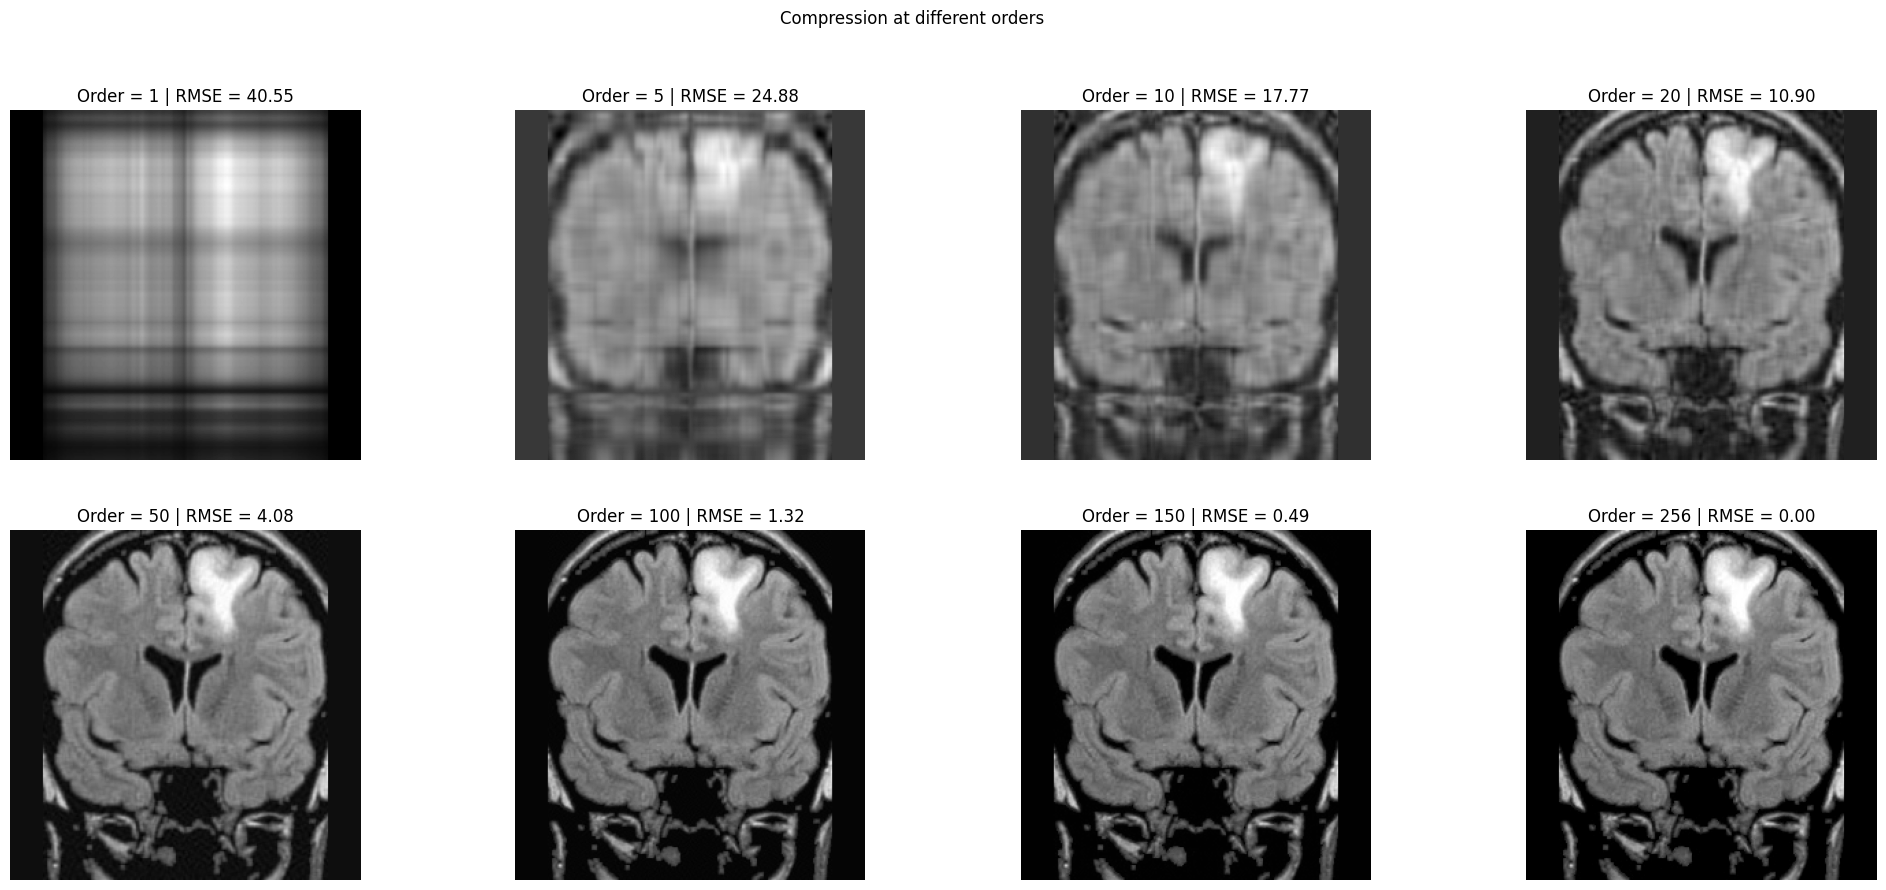

In [15]:
# Convert to Numpy array for the function
gray_image = np.array(gray_image)

orders = [1, 5, 10, 20, 50, 100, 150, 256]
rmse = []

plt.figure(figsize=(25, 10))

for i in tqdm(range(len(orders))):

    # Use the compressor function
    order = orders[i]
    gray_comp = svd_compressor(gray_image, order)

    # Round the calculated values and convert them from float to int.
    gray_comp = np.around(gray_comp).astype(int)

    # Calculate RMSE
    rmse.append(np.sqrt(np.mean((gray_image - gray_comp)**2)))

    # Display the compressed gray image in the subplot
    plt.subplot(2, 4, i + 1)
    plt.title("Order = {} | RMSE = {:.2f}".format(order, rmse[i]))
    plt.axis('off')
    plt.imshow(gray_comp, cmap='gray')

plt.suptitle('Compression at different orders')
plt.show()

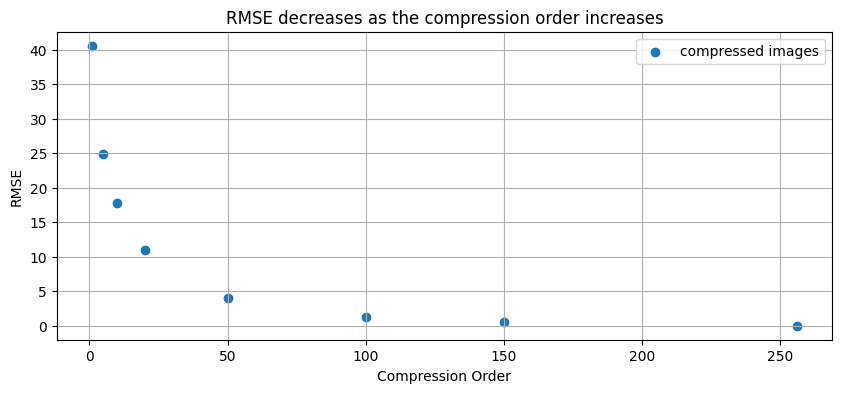

In [44]:
def f(x, a, b, c, d):
    return a * np.log(b * x + c) + d

x_fit = np.linspace(orders[0], orders[-1], 100)
params = curve_fit(f, orders, rmse, bounds=(0,40))
y_fit = f(x_fit, *params[0])

plt.figure(figsize=(10, 4))
plt.scatter(orders, rmse, label="compressed images")
plt.title("RMSE decreases as the compression order increases")
plt.xlabel("Compression Order")
plt.ylabel("RMSE")
plt.grid('on')
plt.legend()
plt.show()

In [12]:
def svd_compress_image_data(images_array):
  comp_images_array = []

  compress_to = 50

  for img in images_array:
    img = array_to_img(img)
    gray_image = img

    gray_image = np.array(gray_image)

    gray_comp = svd_compressor(gray_image, compress_to)

    # Round the calculated values and convert them from float to int.
    gray_comp = np.around(gray_comp).astype(int)

    comp_final = img_to_array(gray_comp)

    comp_images_array.append(comp_final)

  return comp_images_array

In [13]:
def apply_svd(X_dataset):
  data = X_dataset
  data_compressed = svd_compress_image_data(data)

  images_svd = []

  for img in data_compressed:
    # transform image to array
    img = img_to_array(img)

    # append to images
    images_svd.append(img)

  images_svd = np.stack(images_svd)

  return images_svd

In [14]:
X_train_svd = apply_svd(X_train)
X_val_svd = apply_svd(X_val)
X_test_svd = apply_svd(X_test)

## Build CNN

In [15]:
def build_CNN_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  images = tf.keras.layers.Input(shape=(256, 256, 1), dtype=tf.float32, name='Images')

  features = tf.keras.layers.Add()(
      [images])

  conv_1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=5,
    strides=1,
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'
      )(features)

  b1 = layers.BatchNormalization()(conv_1)

  pool_1 = tf.keras.layers.MaxPool2D(
    pool_size=2,
    name='pool_1')(b1)

  conv_2 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=5,
    strides=1,
    padding='same',
    name='conv_2',
    activation='relu')(pool_1)

  b2 = layers.BatchNormalization()(conv_2)

  pool_2 = tf.keras.layers.MaxPool2D(
    pool_size=2, name='pool_2')(b2)

  conv_3 = tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=5,
    strides=1,
    padding='same',
    name='conv_3',
    activation='relu')(pool_2)

  b3 = layers.BatchNormalization()(conv_3)

  pool_3 = tf.keras.layers.MaxPool2D(
    pool_size=2, name='pool_3')(b3)

  flat = tf.keras.layers.Flatten()(pool_3)

  dense = tf.keras.layers.Dense(
    units=1024,
    name='dense',
    activation='relu')(flat)

  drop = tf.keras.layers.Dropout(
    rate=0.5)(dense)

  preds = tf.keras.layers.Dense(
      units=4, activation='softmax', name='Predictions')(drop)

  model = tf.keras.Model(inputs=[images],
                         outputs=preds,
                         name='CNN')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss="sparse_categorical_crossentropy",
      metrics=['accuracy'])

  return model

In [17]:
model_cnn = build_CNN_model()

model_cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Images (InputLayer)         [(None, 256, 256, 1)]     0         
                                                                 
 add (Add)                   (None, 256, 256, 1)       0         
                                                                 
 conv_1 (Conv2D)             (None, 256, 256, 32)      832       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 pool_1 (MaxPooling2D)       (None, 128, 128, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 128, 128, 64)      51264     
                                                               

In [40]:
model_cnn = build_CNN_model_mod()

model_cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Images (InputLayer)         [(None, 256, 256, 1)]     0         
                                                                 
 add (Add)                   (None, 256, 256, 1)       0         
                                                                 
 conv_1 (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 pool_1 (MaxPooling2D)       (None, 85, 85, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 85, 85, 64)        18496     
                                                               

Shape of image: (1, 256, 256, 1)


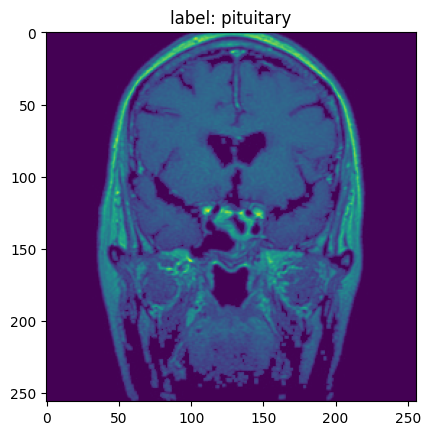

In [38]:
img_tensor = np.expand_dims(X_train[2], axis = 0);
label_names = ['normal', 'glioma', 'meningioma', 'pituitary']
# Print image tensor shape
print('Shape of image:', img_tensor.shape);

# Print image
plt.imshow(img_tensor[0]);
plt.title('label: ' + label_names[y_train[2]])
plt.show()

1/1 [==============================] - 0s 232ms/step
----------------
Getting activations of layer 2 : conv_1
Images size is 256 x 256
Number of channels is 32
Printing channels:


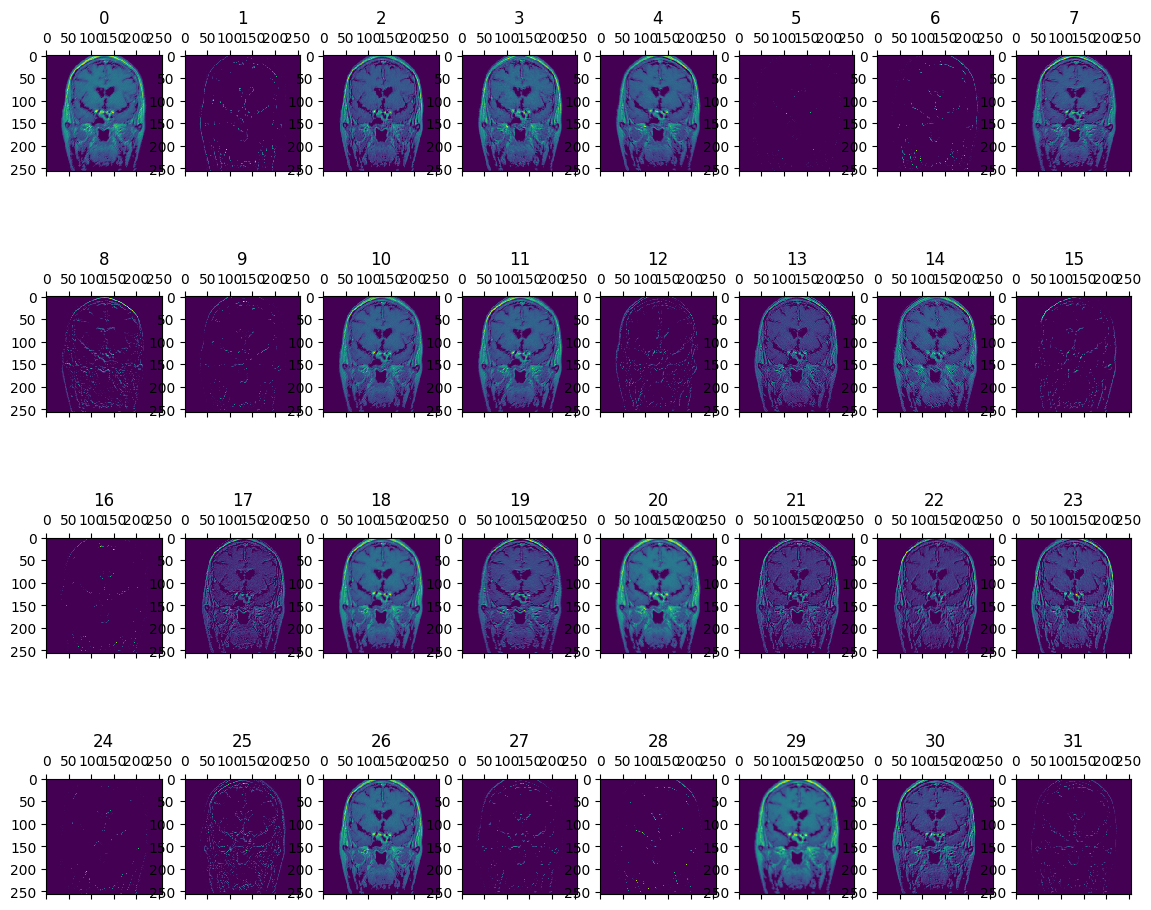

----------------
Getting activations of layer 3 : batch_normalization
Images size is 256 x 256
Number of channels is 32
Printing channels:


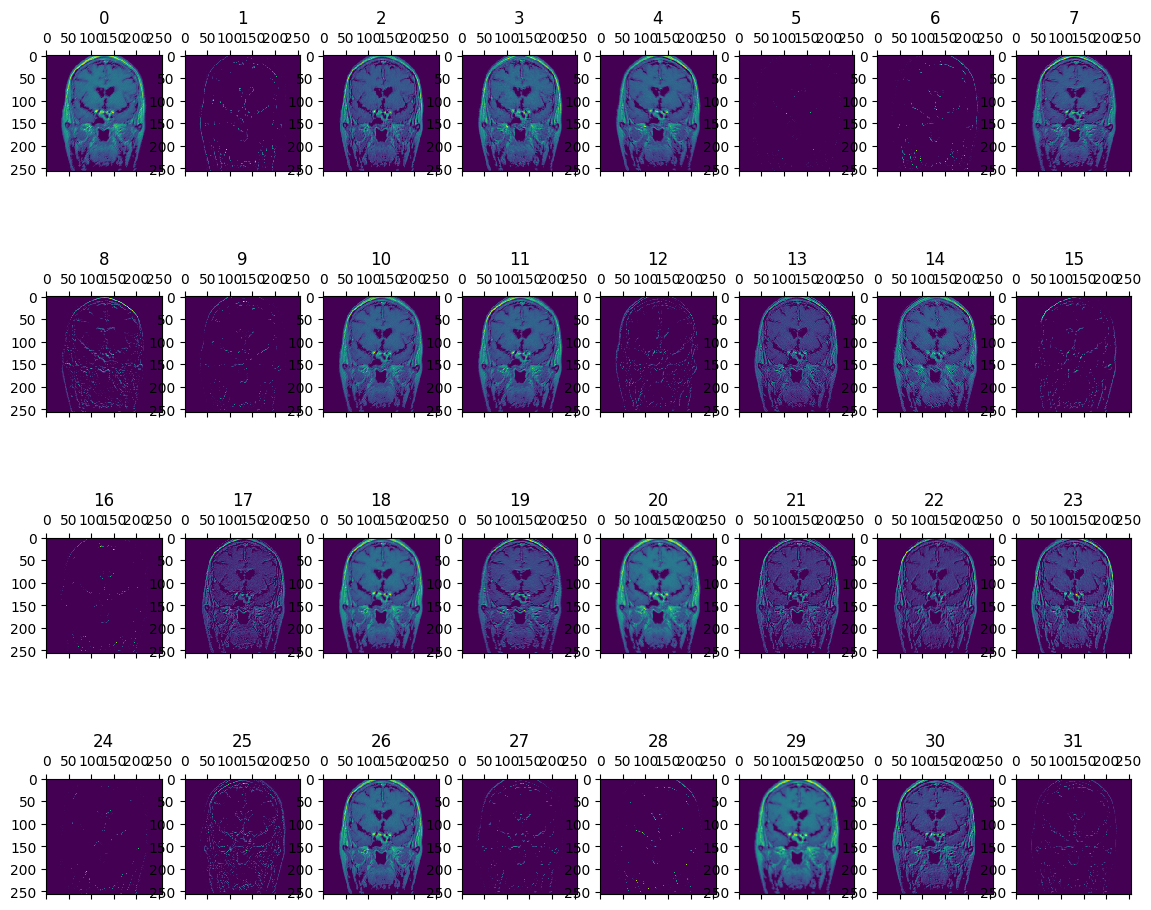

----------------
Getting activations of layer 4 : pool_1
Images size is 85 x 85
Number of channels is 32
Printing channels:


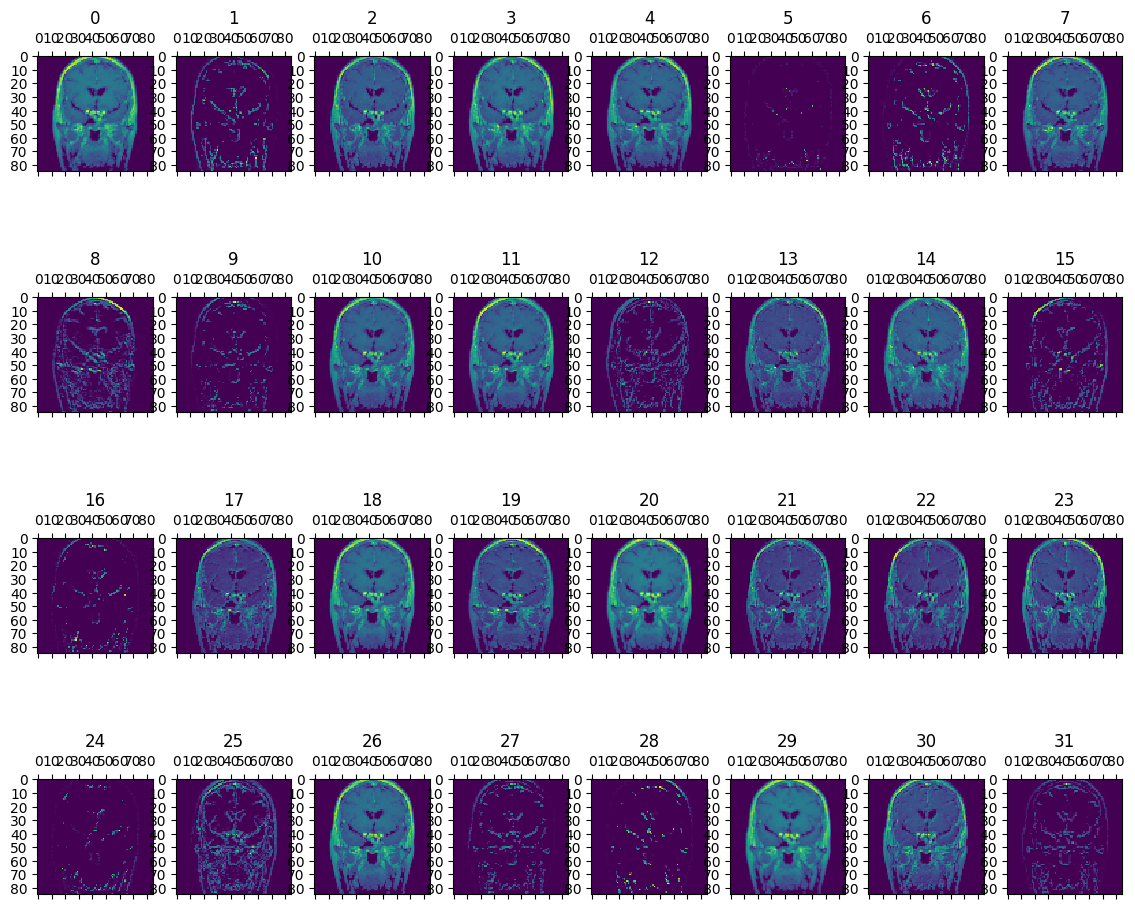

----------------
Getting activations of layer 5 : conv_2
Images size is 85 x 85
Number of channels is 64
Printing channels:


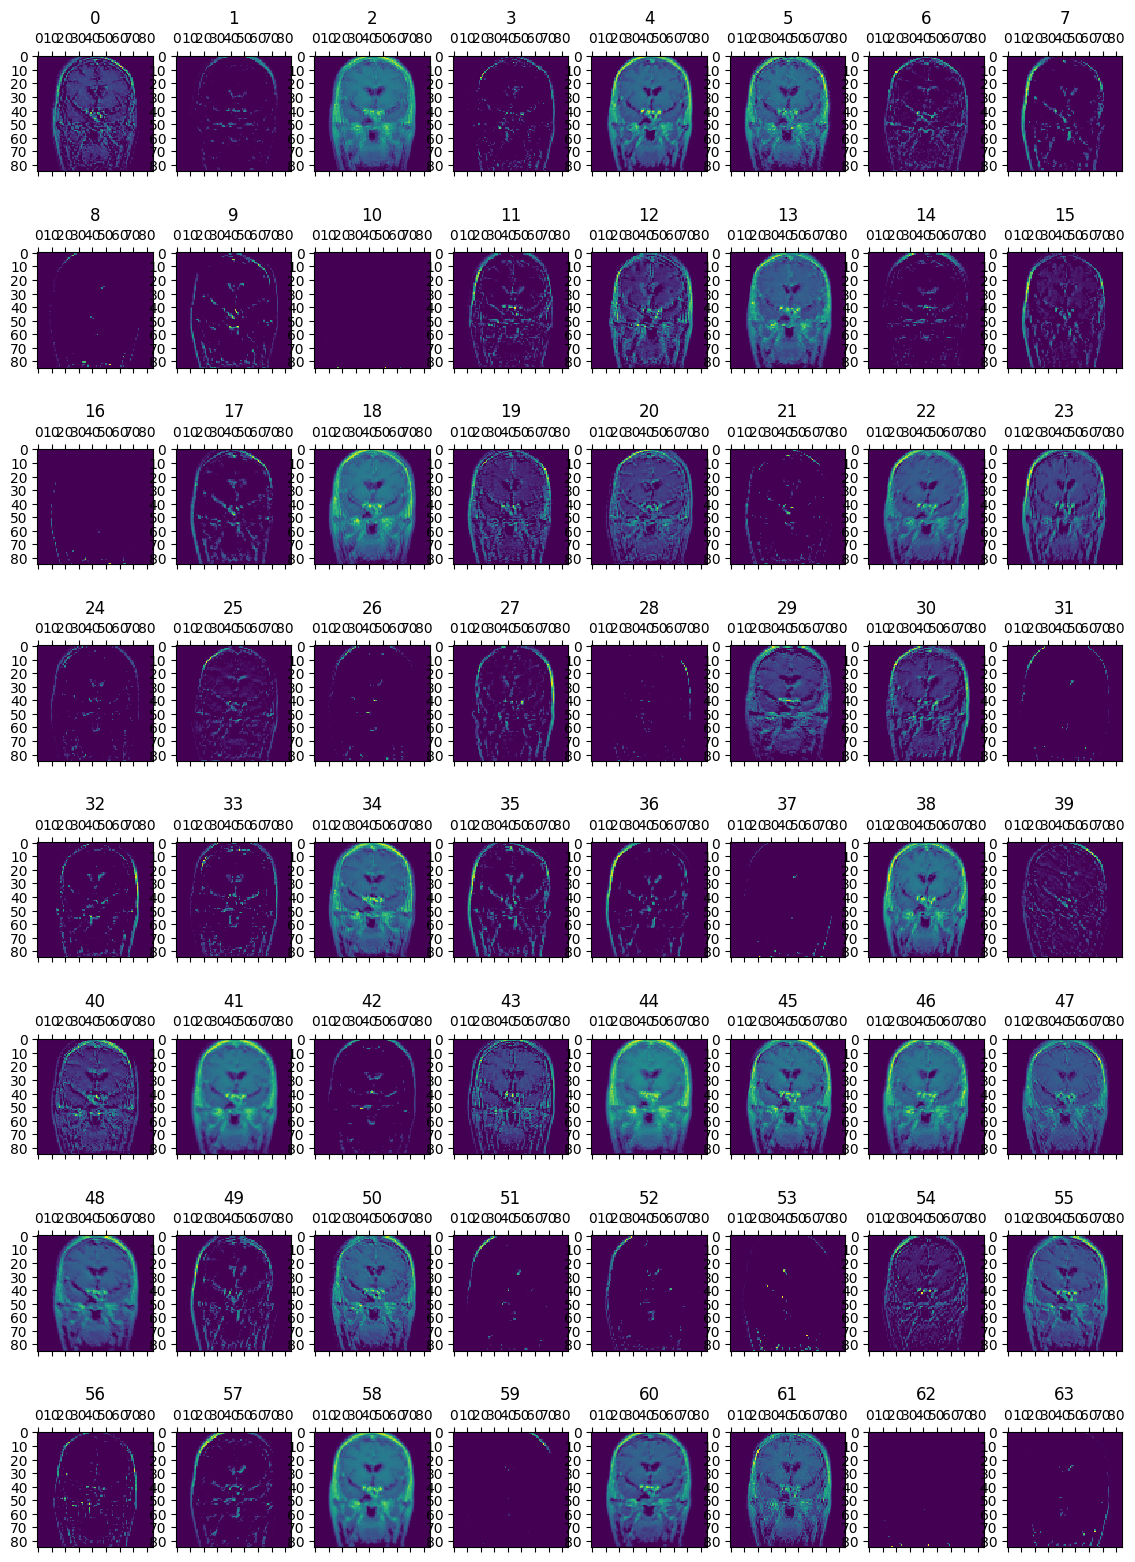

----------------
Getting activations of layer 6 : batch_normalization_1
Images size is 85 x 85
Number of channels is 64
Printing channels:


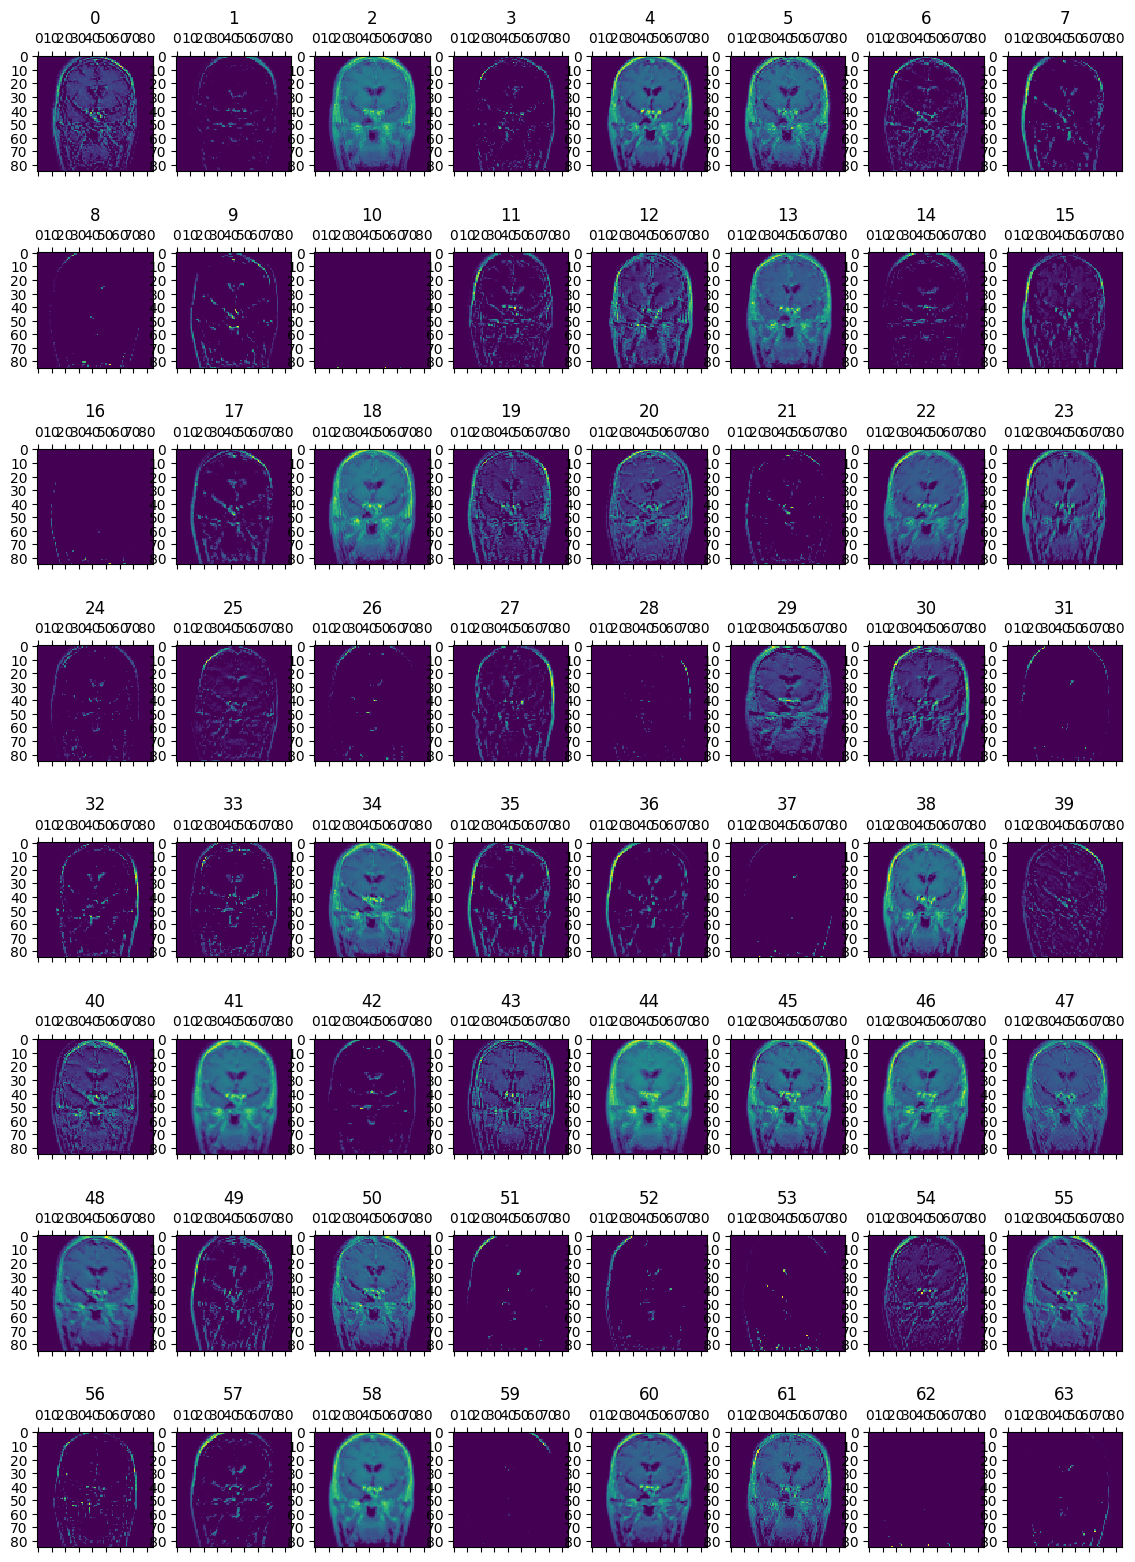

----------------
Getting activations of layer 7 : pool_2
Images size is 28 x 28
Number of channels is 64
Printing channels:


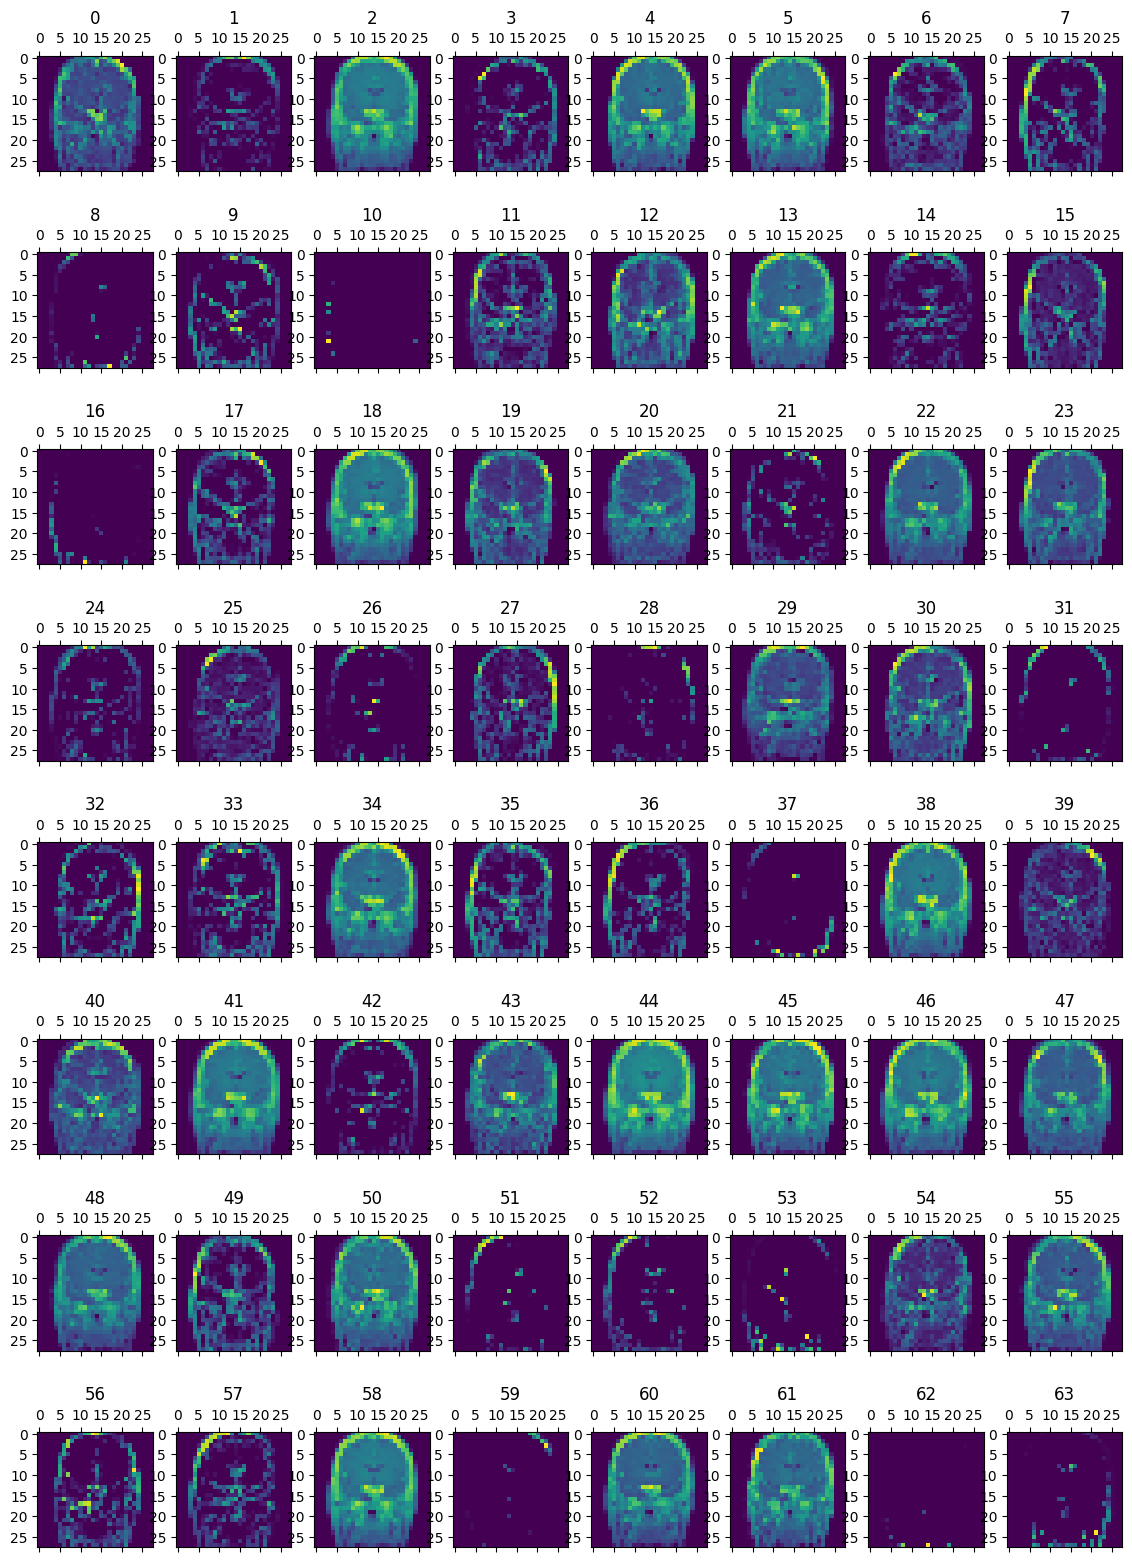

----------------
Getting activations of layer 8 : conv_3
Images size is 28 x 28
Number of channels is 128
Printing channels:


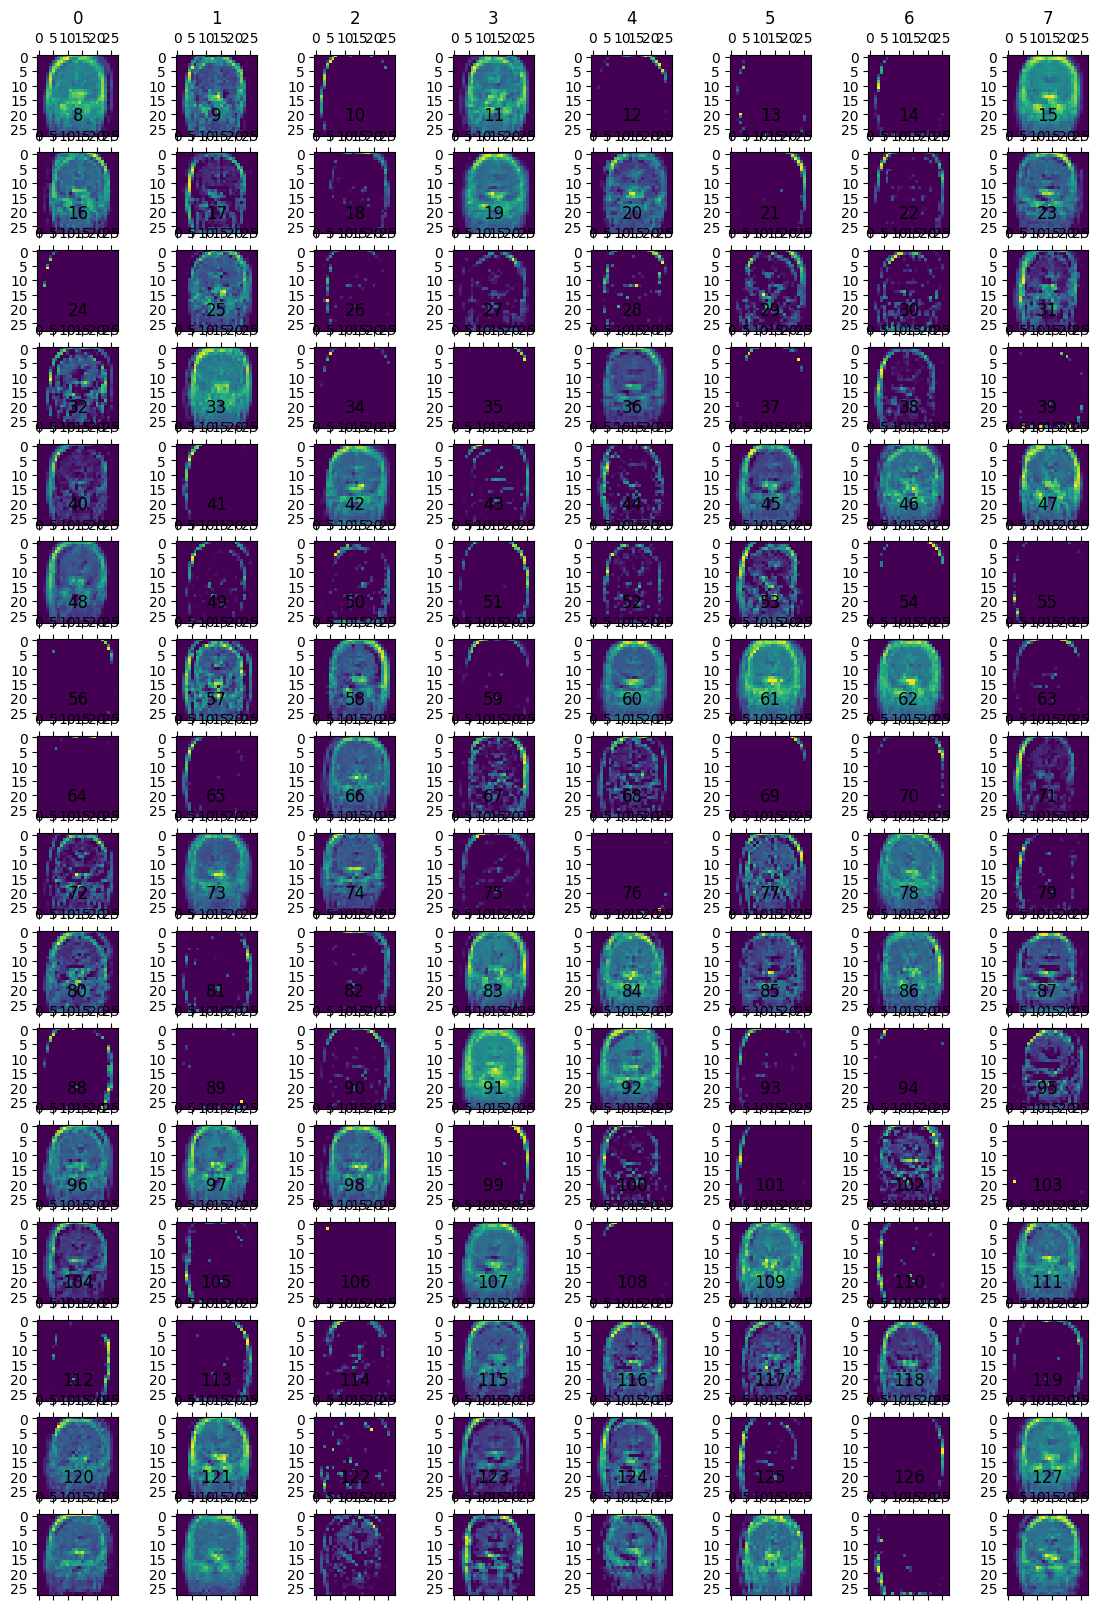

----------------
Getting activations of layer 9 : batch_normalization_2
Images size is 28 x 28
Number of channels is 128
Printing channels:


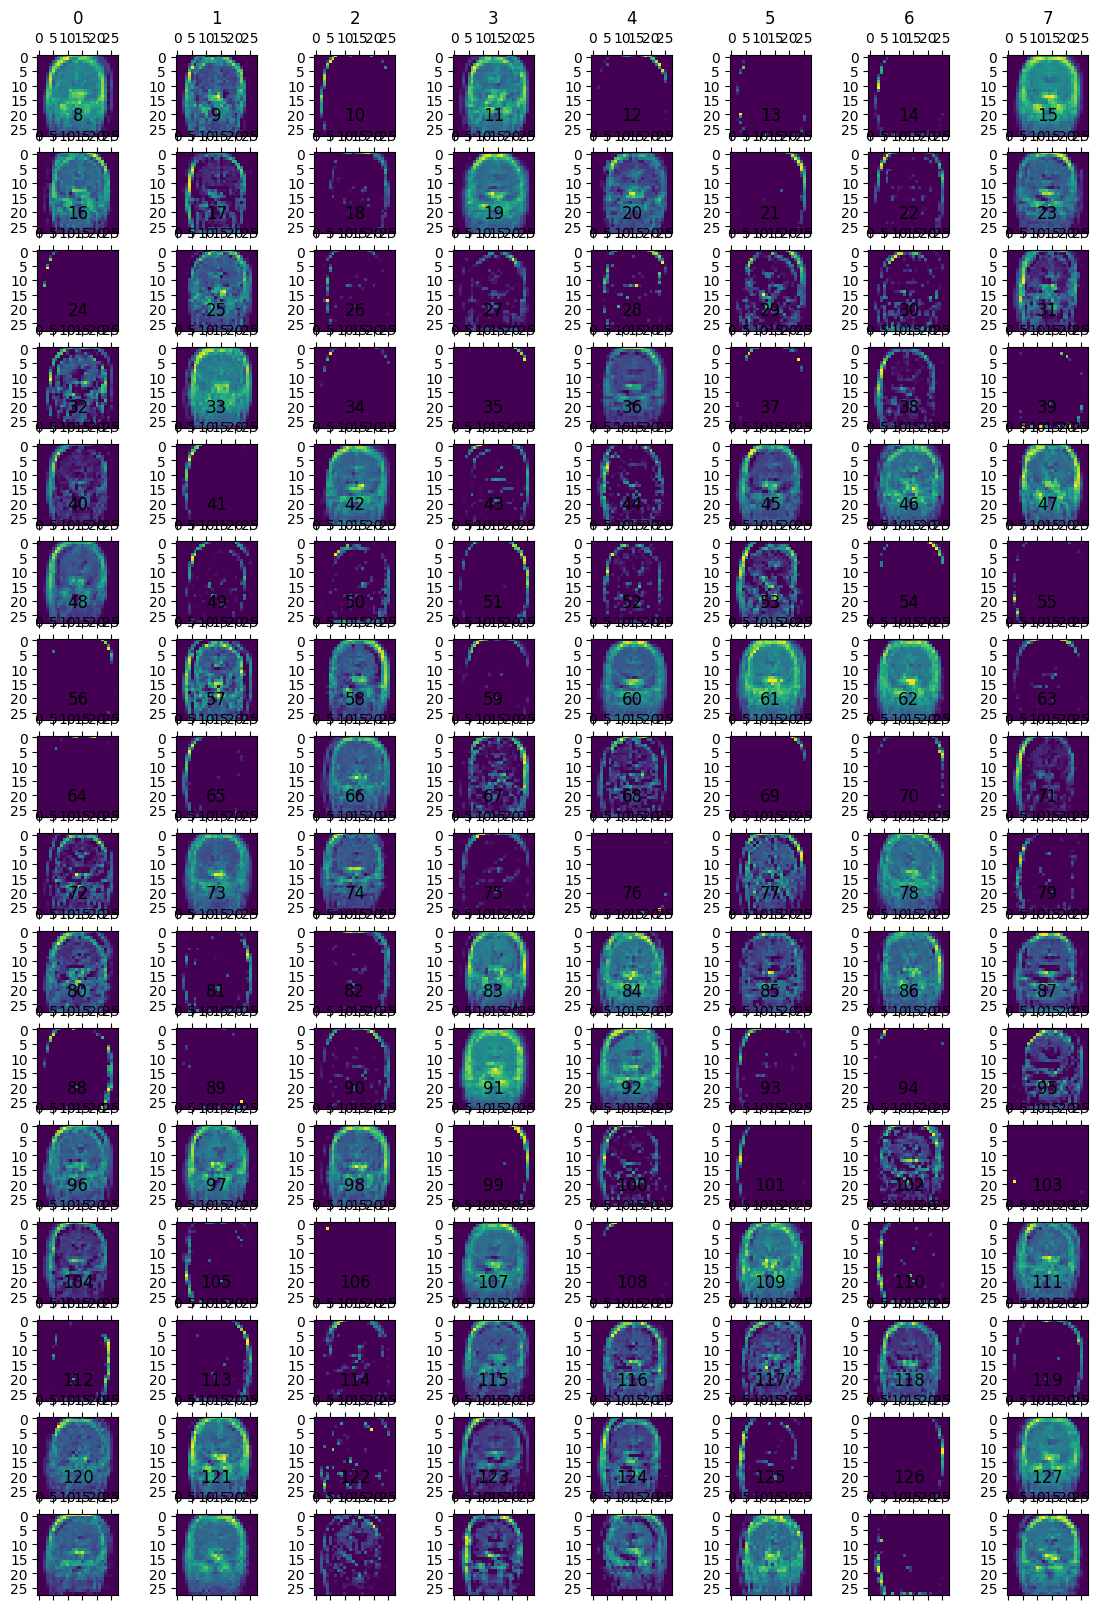

----------------
Getting activations of layer 10 : pool_3
Images size is 9 x 9
Number of channels is 128
Printing channels:


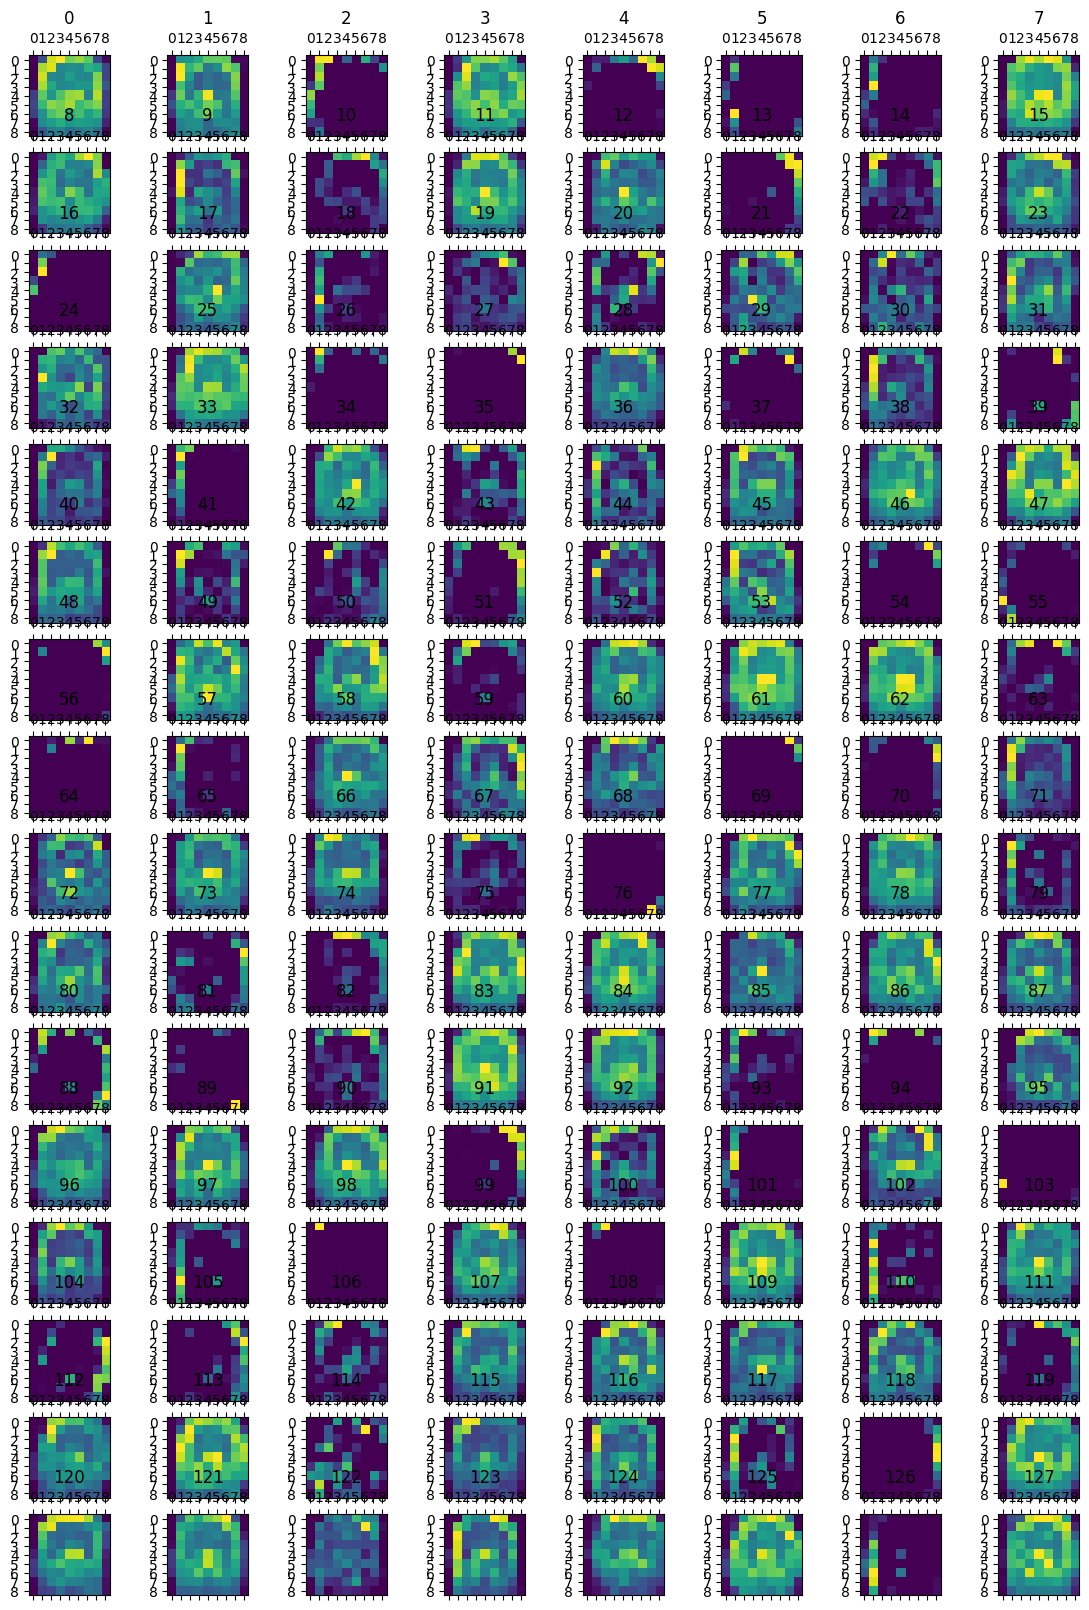

In [41]:
# outputs of the first 6 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model_cnn.layers[1:11]]
activation_model = models.Model(inputs = model_cnn.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

# grab layer names
layer_names = []
for layer in model_cnn.layers[1:11]:
    layer_names.append(layer.name)

# getting activations of each layer
for idx, layer in enumerate(activations):
    if idx in (1,2,3,4,5,6,7,8,9,10):
        print('----------------')
        print('Getting activations of layer',  idx+1, ':', layer_names[idx])
        activation = layer

        # shape of layer activation
        print('Images size is', activation.shape[1], 'x', activation.shape[2])
        print('Number of channels is', activation.shape[3])

        # print channels
        print('Printing channels:')

        # define nrows and ncols depending on number of channels
        if idx in (1,2,3):
            nrows, ncols = 4,8
        if idx in (4,5,6):
            nrows, ncols = 8,8
        if idx in (7,8,9,10):
            nrows, ncols = 16,8

        # plots
        channel=0
        if idx in (1,2,3):
            f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
        if idx in (4,5,6):
            f, axs = plt.subplots(nrows, ncols, figsize=(14,20))
        if idx in (7,8,9,10):
            f, axs = plt.subplots(nrows, ncols, figsize=(14,20))

        for i in range(nrows):
            for j in range(ncols):
                if i==0 and j==0:
                    channel=0
                else:
                    channel+=1

                axs[i,j].matshow(activation[0,:, :, channel], cmap ='viridis')
                axs[i,j].set(title=str(channel))
                #axs[i,j].axis('off') # pay attention to the range of x and y axis
        plt.show()

In [21]:
model_cnn = build_CNN_model()

history = model_cnn.fit(
  x={
      'Images': X_train_svd
    },
  y=y_train,
  epochs=20,
  validation_data=(
      {
        'Images': X_val_svd
      },
      y_val)
)

Epoch 1/20
66/66 [==============================] - 12s 148ms/step - loss: 29.9799 - accuracy: 0.4881 - val_loss: 70.7461 - val_accuracy: 0.3571
Epoch 2/20
66/66 [==============================] - 9s 132ms/step - loss: 2.0940 - accuracy: 0.5756 - val_loss: 8.6372 - val_accuracy: 0.4829
Epoch 3/20
66/66 [==============================] - 9s 138ms/step - loss: 1.5011 - accuracy: 0.6089 - val_loss: 6.4617 - val_accuracy: 0.5343
Epoch 4/20
66/66 [==============================] - 8s 126ms/step - loss: 1.1208 - accuracy: 0.6513 - val_loss: 1.5284 - val_accuracy: 0.7143
Epoch 5/20
66/66 [==============================] - 8s 124ms/step - loss: 1.3690 - accuracy: 0.6375 - val_loss: 1.8135 - val_accuracy: 0.7400
Epoch 6/20
66/66 [==============================] - 8s 122ms/step - loss: 1.1927 - accuracy: 0.6503 - val_loss: 2.3642 - val_accuracy: 0.7286
Epoch 7/20
66/66 [==============================] - 8s 125ms/step - loss: 0.8128 - accuracy: 0.6898 - val_loss: 1.9199 - val_accuracy: 0.7657
Epo

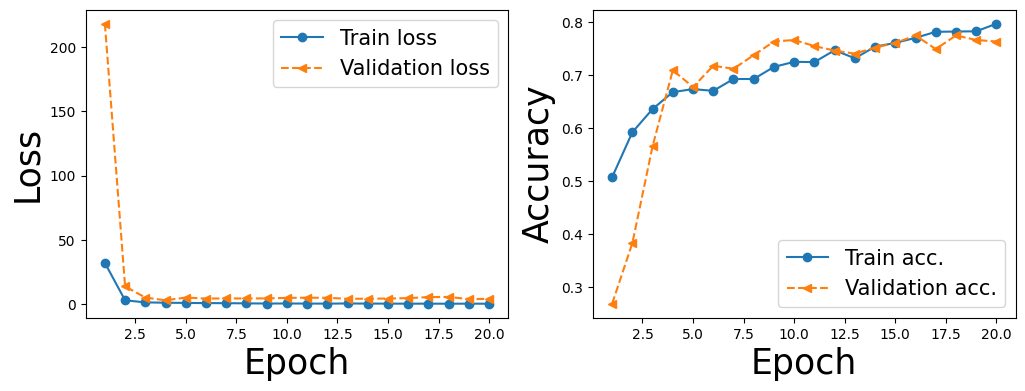

In [25]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=25)
ax.set_ylabel('Loss', size=25)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=25)
ax.set_ylabel('Accuracy', size=25)
plt.show()

## Hyperparameter Tuning

In [16]:
#hyperparameter tuning

#svd 100 instead of 50

def svd_compress_image_data100(images_array):
  comp_images_array = []

  compress_to = 100

  for img in images_array:
    img = array_to_img(img)
    gray_image = img

    gray_image = np.array(gray_image)

    gray_comp = svd_compressor(gray_image, compress_to)

    # Round the calculated values and convert them from float to int.
    gray_comp = np.around(gray_comp).astype(int)

    comp_final = img_to_array(gray_comp)

    comp_images_array.append(comp_final)

  return comp_images_array

def apply_svd100(X_dataset):
  data = X_dataset
  data_compressed = svd_compress_image_data100(data)

  images_svd = []

  for img in data_compressed:
    # transform image to array
    img = img_to_array(img)

    # append to images
    images_svd.append(img)

  images_svd = np.stack(images_svd)

  return images_svd

X_train_svd100 = apply_svd100(X_train)
X_val_svd100 = apply_svd100(X_val)
X_test_svd100 = apply_svd100(X_test)

model_cnn = build_CNN_model()

history = model_cnn.fit(
  x={
      'Images': X_train_svd100
    },
  y=y_train,
  epochs=20,
  validation_data=(
      {
        'Images': X_val_svd100
      },
      y_val)
)

In [42]:
#hyperparameter tuning
def build_CNN_model_mod():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  images = tf.keras.layers.Input(shape=(256, 256, 1), dtype=tf.float32, name='Images')

  features = tf.keras.layers.Add()(
      [images])

  conv_1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'
      )(features)

  b1 = layers.BatchNormalization()(conv_1)

  pool_1 = tf.keras.layers.MaxPool2D(
    pool_size=2,
    name='pool_1')(b1)

  conv_2 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    name='conv_2',
    activation='relu')(pool_1)

  b2 = layers.BatchNormalization()(conv_2)

  pool_2 = tf.keras.layers.MaxPool2D(
    pool_size=2, name='pool_2')(b2)

  conv_3 = tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=3,
    strides=1,
    padding='same',
    name='conv_3',
    activation='relu')(pool_2)

  b3 = layers.BatchNormalization()(conv_3)

  pool_3 = tf.keras.layers.MaxPool2D(
    pool_size=2, name='pool_3')(b3)

  flat = tf.keras.layers.Flatten()(pool_3)

  dense = tf.keras.layers.Dense(
    units=1024,
    name='dense',
    activation='relu')(flat)

  drop = tf.keras.layers.Dropout(
    rate=0.5)(dense)

  preds = tf.keras.layers.Dense(
      units=4, activation='softmax', name='Predictions')(drop)

  model = tf.keras.Model(inputs=[images],
                         outputs=preds,
                         name='CNN')
  model.compile(
      optimizer=tf.keras.optimizers.SGD(),
      loss="sparse_categorical_crossentropy",
      metrics=['accuracy'])

  return model


In [43]:
model_cnn = build_CNN_model_mod()

history = model_cnn.fit(
  x={
      'Images': X_train_svd
    },
  y=y_train,
  epochs=20,
  validation_data=(
      {
        'Images': X_val_svd
      },
      y_val)
)

Epoch 1/20
66/66 [==============================] - 15s 149ms/step - loss: 4.5221 - accuracy: 0.4619 - val_loss: 3.3765 - val_accuracy: 0.2714
Epoch 2/20
66/66 [==============================] - 7s 106ms/step - loss: 0.9573 - accuracy: 0.6132 - val_loss: 1.5020 - val_accuracy: 0.4600
Epoch 3/20
66/66 [==============================] - 7s 107ms/step - loss: 0.7798 - accuracy: 0.6841 - val_loss: 1.1861 - val_accuracy: 0.5800
Epoch 4/20
66/66 [==============================] - 7s 106ms/step - loss: 0.6334 - accuracy: 0.7450 - val_loss: 0.8060 - val_accuracy: 0.7486
Epoch 5/20
66/66 [==============================] - 7s 106ms/step - loss: 0.5264 - accuracy: 0.7978 - val_loss: 0.8667 - val_accuracy: 0.7400
Epoch 6/20
66/66 [==============================] - 7s 106ms/step - loss: 0.4442 - accuracy: 0.8297 - val_loss: 0.7460 - val_accuracy: 0.7743
Epoch 7/20
66/66 [==============================] - 7s 105ms/step - loss: 0.3733 - accuracy: 0.8549 - val_loss: 0.7640 - val_accuracy: 0.7857
Epoch

In [17]:
#hyperparameter tuning
#no flip / no data augmentation

def preprocess_data_part2_mod(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 256, 256, 1)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 256, 256, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 256, 256, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 256, 224, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    shuffle = np.random.permutation(np.arange(len(images)))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

    # rescale image to [0,1]
    X_train = tf.image.rgb_to_grayscale(X_train)/255.0
    X_val = tf.image.rgb_to_grayscale(X_val)/255.0
    X_test = tf.image.rgb_to_grayscale(X_test)/255.0

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train_mod, y_train_mod, X_val_mod, y_val_mod, X_test_mod, y_test_mod = preprocess_data_part2_mod(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

X_train_svd_mod = apply_svd(X_train_mod)
X_val_svd_mod = apply_svd(X_val_mod)
X_test_svd_mod = apply_svd(X_test_mod)

model_cnn = build_CNN_model_mod()

history = model_cnn.fit(
  x={
      'Images': X_train_svd_mod
    },
  y=y_train_mod,
  epochs=20,
  validation_data=(
      {
        'Images': X_val_svd_mod
      },
      y_val_mod)
)

*Hyperparameter Tuning*:

| Training accuracy | Validation accuracy |  kernel size |  strides | pool size  |  learning rate | optimizer  | SVD order |  flip_on_train  |
|:-:                |:-:                             |:-:       |:-:         |:-:             |:-:         |:-:                 |:-:               |:-:             |
| 0.7797              | 0.7971                | 5          | 1      | 2        | 0.001          | Adam       | 50                | yes            |
| 0.8544               | 0.8029                 | <font color="red">3</font>     | 1      | 2        | 0.001          | Adam       | 50                |  yes            |
| 0.9772               | 0.6629                 | 5          | <font color="red">2</font>  | 2        | 0.001          | Adam       | 50                | yes            |
| 0.9177               | 0.8229                 | 5          | 1      | <font color="red">3</font>   | 0.001          | Adam       | 50                | yes            |
| 0.2612               | 0.2629                 | 5          | 1      | 2        | <font color="red">0.01</font>       | Adam       | 50                |  yes            |
| 0.9600               | 0.8086                 | 5          | 1      | 2        | 0.001          |<font color="red">SGD</font>     | 50                |  yes            |
| 0.8083               | 0.7629                 | 5          | 1      | 2        | 0.001          | Adam       | <font color="red">100</font>            | yes            |
| 0.9096               | 0.8257                 | 5          | 1      | 2        | 0.001          | Adam       | 50                | <font color="red">no</font>         |

*Additional tests*:

| Training accuracy | Validation accuracy |  kernel size |  strides | pool size  |  learning rate | optimizer  | SVD order |  flip_on_train  |
|:-:                |:-:                             |:-:       |:-:         |:-:             |:-:         |:-:                 |:-:               |:-:             |
| 0.9510              | 0.8029                | <font color="red">3</font>          | 1      | <font color="red">3</font>        | 0.001          | Adam       | 50                | yes            |
|      0.9324         |    0.7829             | <font color="red">3</font>          | 1      | <font color="red">3</font>        | 0.001          | Adam       | 50                | <font color="red">no</font>            |
|       0.8896         |         0.8086        | <font color="red">3</font>     | 1      | 2        | 0.001          | Adam       | 50                |  <font color="red">no</font>            |
|     0.8792           |         0.8114         | 5          | 1  | <font color="red">3</font>        | 0.001          | Adam       | 50                | <font color="red">no</font>            |
|        0.9924        |    0.8400              | <font color="red">3</font>          | 1      | <font color="red">3</font>   | 0.001          | <font color="red">SGD</font>       | 50                | yes            |
|     0.9838          |        0.8400         | <font color="red">3</font>          | 1      | <font color="red">3</font>        | 0.001          | <font color="red">SGD</font>       | 50                | <font color="red">no</font>            |
|       0.9857         |     0.8057             | <font color="red">3</font>          | 1      | 2        | 0.001      | <font color="red">SGD</font>       | 50                |  <font color="red">no</font>            |
|        0.9800        |         0.8400         | 5          | 1      | <font color="red">3</font>        | 0.001          |<font color="red">SGD</font>     | 50                |  <font color="red">no</font>            |

Final model parameters:


*   kernel size: 3
*   strides: 1
*   pool size: 3
*   learning rate: 0.001
*   optimizer: SGD
*   SVD order: 50
*   flip: yes

## Analyze Results

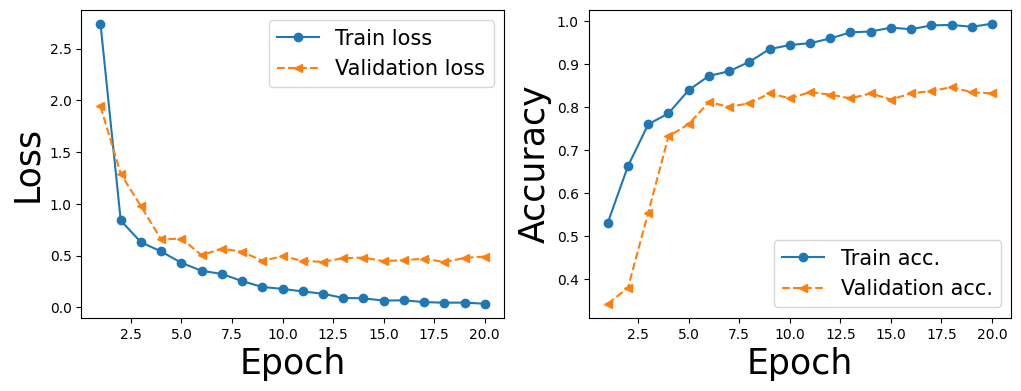

In [54]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=25)
ax.set_ylabel('Loss', size=25)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=25)
ax.set_ylabel('Accuracy', size=25)
plt.show()

In [39]:
val_results = model_cnn.evaluate(X_val_svd, y_val)
print('\nVal Acc. {:.2f}%'.format(val_results[1]*100))

test_results = model_cnn.evaluate(X_test_svd, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))


11/11 [==============================] - 0s 17ms/step - loss: 0.4903 - accuracy: 0.8314

Val Acc. 83.14%
11/11 [==============================] - 0s 18ms/step - loss: 0.7199 - accuracy: 0.7892

Test Acc. 78.92%


In [40]:
pred = model_cnn.predict(X_test_svd)
test_predictions = np.argmax(pred, axis=-1)

11/11 [==============================] - 0s 17ms/step


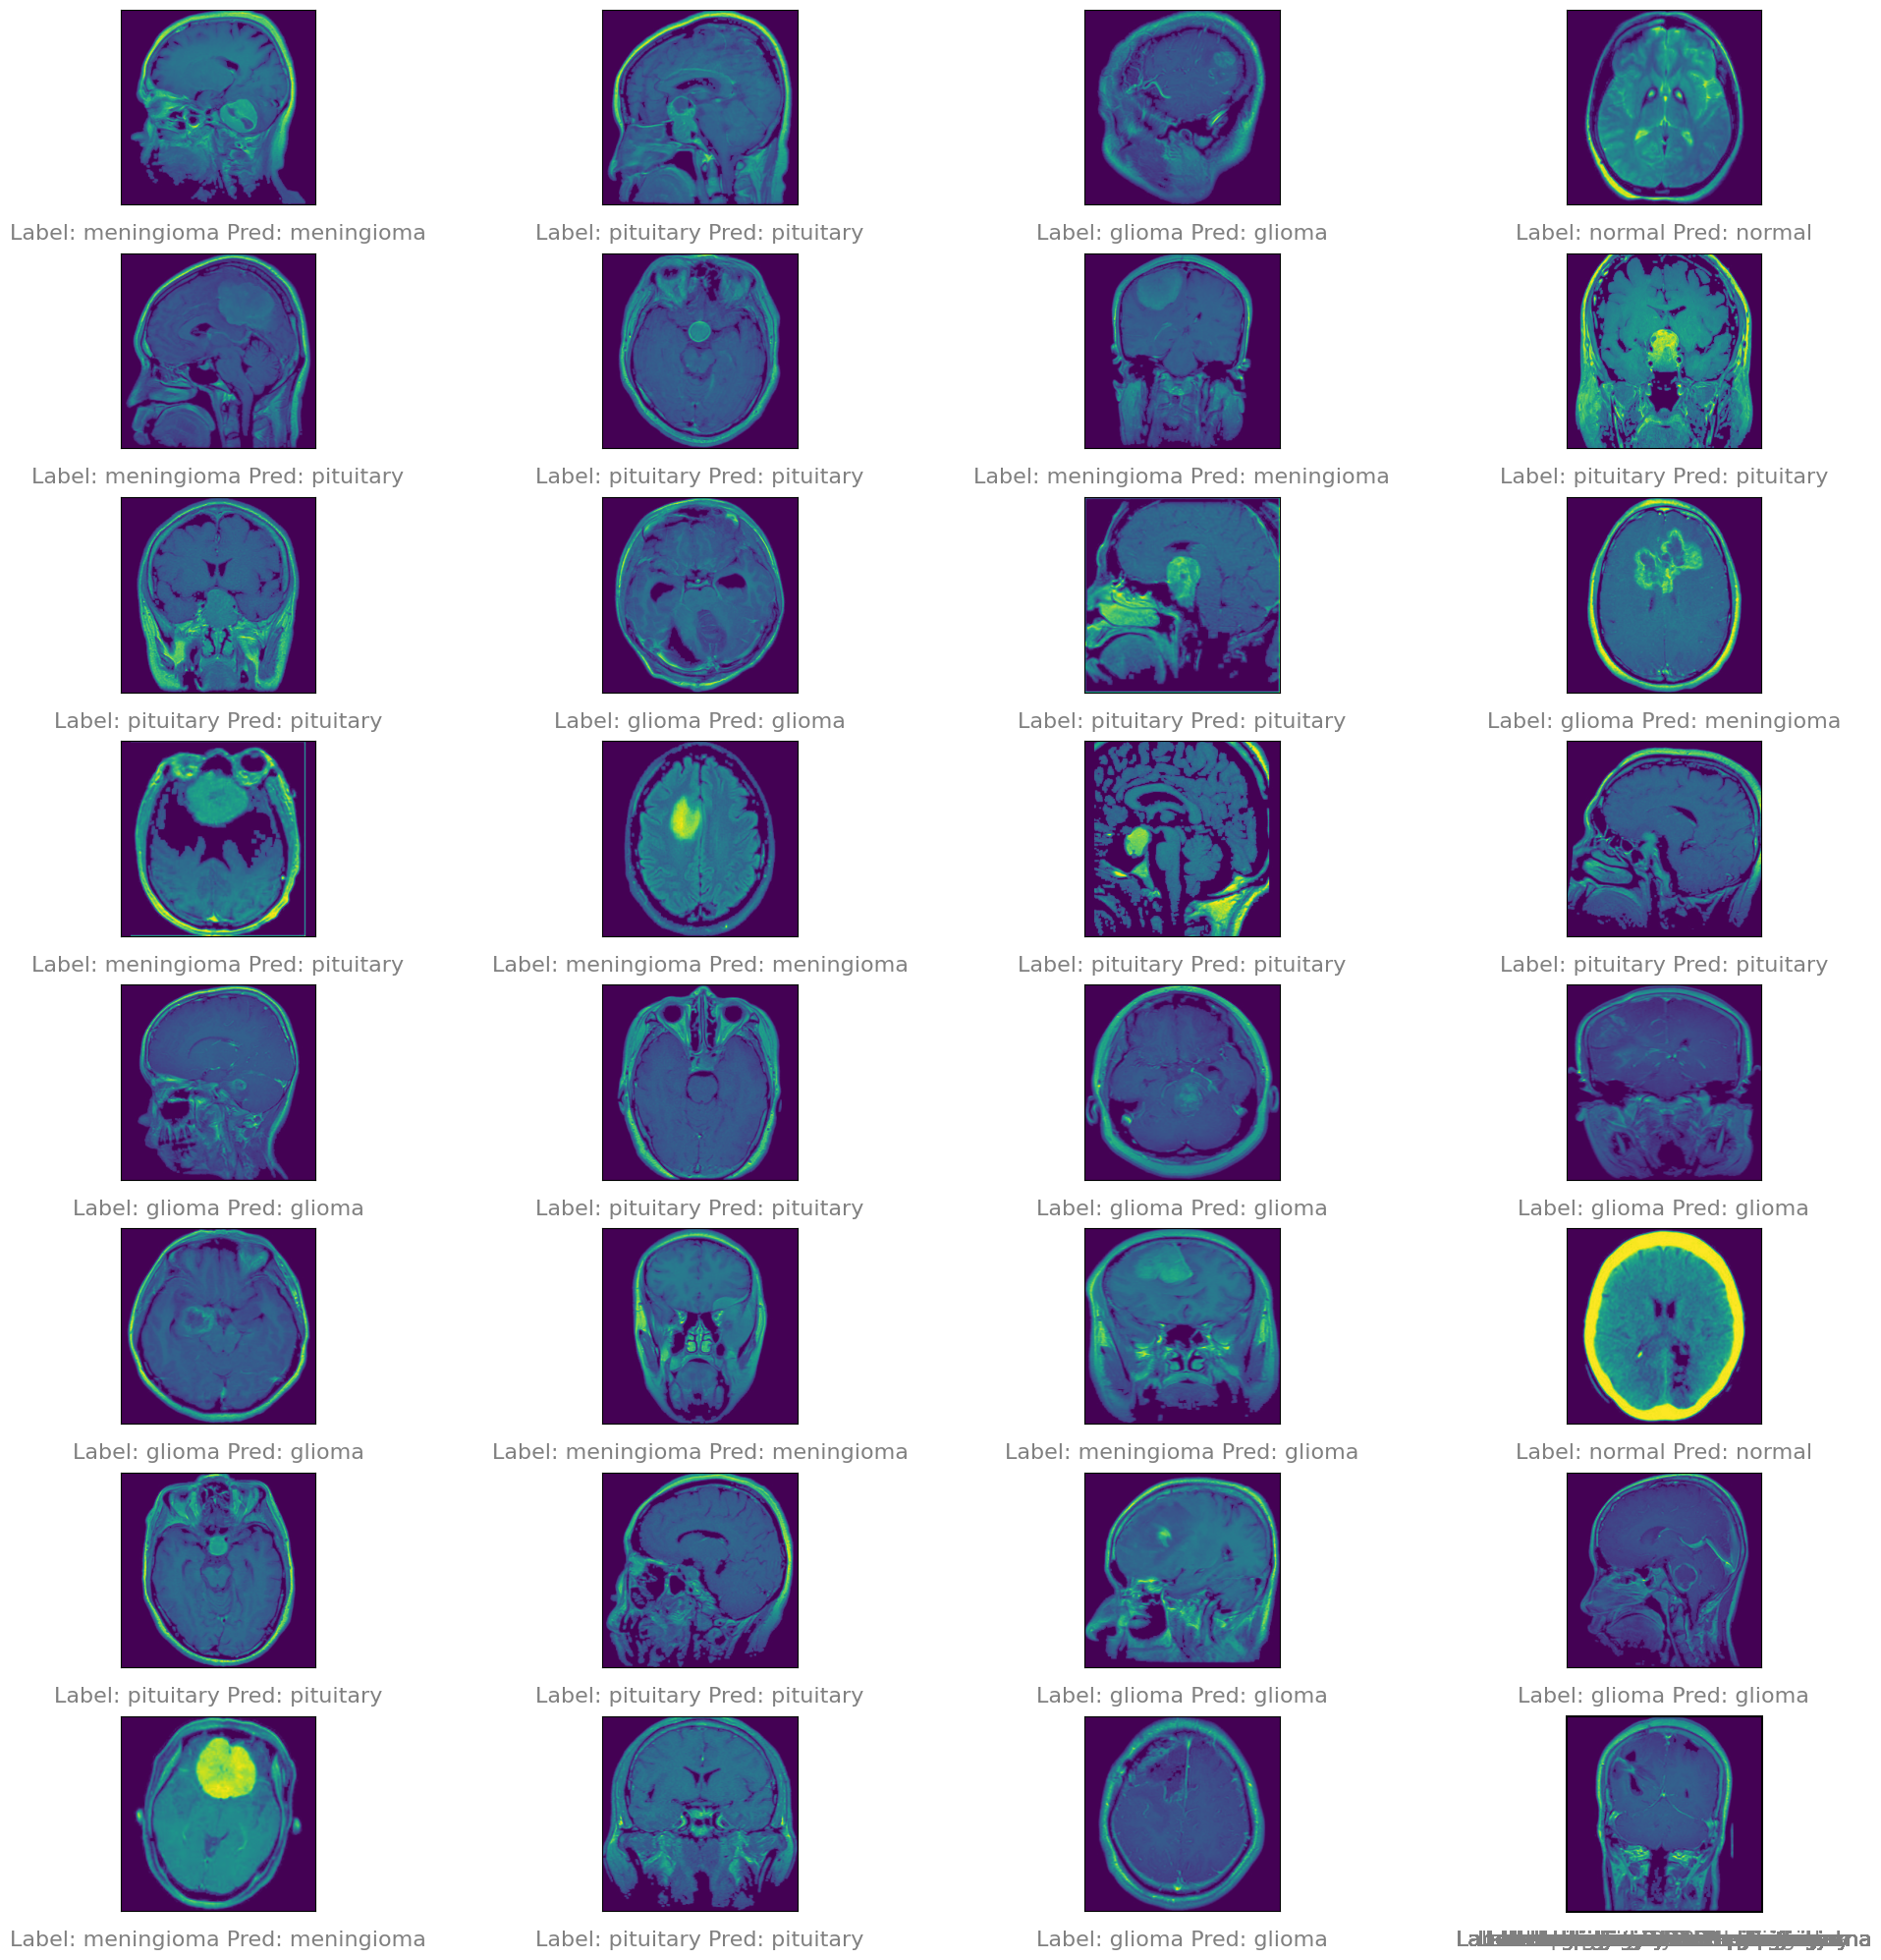

In [49]:
# plot test data, label, and label prediction
fig = plt.figure(figsize=(20, 20))
label_names = ['normal', 'glioma', 'meningioma', 'pituitary']

for j, example in enumerate(X_test):
    ax = fig.add_subplot(8,4, min(j+1, 32))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    label = label_names[y_test[j]]


    ax.text(
        0.5, -0.15,
        'Label: {:s} Pred: {:s}'.format(label, label_names[test_predictions[j]]),
        size=16,
        color='grey',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)

plt.tight_layout()
plt.show()

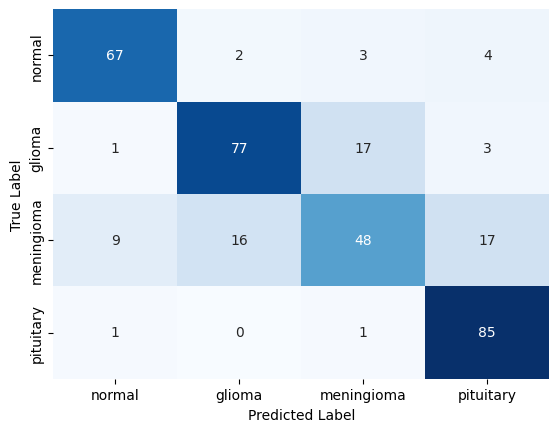

In [44]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()